In [5]:
# Resume training from checkpoint
resume_from_checkpoint = True
checkpoint_path = "C:/Users/maril/OneDrive/Desktop/GitHub/OADino/runs/ConvVAE64_MNIST_20260213_130237/checkpoints/checkpoint_epoch_20.pt"

# ConvVAE64 MNIST Training & Testing

This notebook trains and tests the ConvVAE64 model on MNIST dataset for baseline validation.

## 1. Setup & Imports

In [6]:
# Fix numpy/pandas compatibility issue
import sys
!{sys.executable} -m pip install --upgrade numpy pandas scikit-learn --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.61.0 requires numpy<2.2,>=1.24, but you have numpy 2.4.2 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.4.2 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.8.0 which is incompatible.
streamlit 1.45.1 requires pandas<3,>=1.4.0, but you have pandas 3.0.0 which is incompatible.


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
from tqdm import tqdm
import json
from datetime import datetime

# Import the ConvVAE64 model
import sys
sys.path.insert(0, os.path.dirname(os.path.abspath('')))
from oadino.models import ConvVAE64

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 2. Data Preparation

In [8]:
# Define transforms
# ConvVAE64 expects 64x64 input
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel for ConvVAE64
    transforms.ToTensor(),
])

# Download and load MNIST
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Split train into train and validation
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

print(f"Train set: {len(train_dataset)}")
print(f"Validation set: {len(val_dataset)}")
print(f"Test set: {len(test_dataset)}")

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train set: 54000
Validation set: 6000
Test set: 10000
Train batches: 844
Validation batches: 94
Test batches: 157


## 3. Model Initialization

In [9]:
# Initialize model
model = ConvVAE64()
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Optimizer
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

print(f"Optimizer: Adam with lr={learning_rate}")

Total parameters: 1,497,859
Trainable parameters: 1,497,859
Optimizer: Adam with lr=0.001


## 4. Loss Functions

In [10]:
def vae_loss(recon_x, x, mean, logvar, beta=1.0):
    """VAE loss = Reconstruction loss + β * KL divergence"""
    # Reconstruction loss (MSE)
    recon_loss = nn.MSELoss(reduction='mean')(recon_x, x)
    
    # KL divergence loss
    # KL(N(mean, var) || N(0, 1)) = 0.5 * sum(mean^2 + var - 1 - log(var))
    kl_loss = -0.5 * torch.mean(1 + logvar - mean.pow(2) - logvar.exp())
    
    total_loss = recon_loss + beta * kl_loss
    return total_loss, recon_loss, kl_loss

print("Loss function defined: VAE loss = MSE + β*KL")

Loss function defined: VAE loss = MSE + β*KL


## 5. Training Loop

In [11]:
def train_epoch(model, train_loader, optimizer, device, beta=1.0):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    total_recon_loss = 0
    total_kl_loss = 0
    
    pbar = tqdm(train_loader, desc="Training")
    for images, _ in pbar:
        images = images.to(device)
        
        # Forward pass
        recon_images, mean, logvar = model(images)
        
        # Compute loss
        loss, recon_loss, kl_loss = vae_loss(recon_images, images, mean, logvar, beta=beta)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # Accumulate losses
        total_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_kl_loss += kl_loss.item()
        
        pbar.set_postfix({
            'loss': loss.item(),
            'recon': recon_loss.item(),
            'kl': kl_loss.item()
        })
    
    avg_loss = total_loss / len(train_loader)
    avg_recon_loss = total_recon_loss / len(train_loader)
    avg_kl_loss = total_kl_loss / len(train_loader)
    
    return avg_loss, avg_recon_loss, avg_kl_loss

print("Training function defined")

Training function defined


## 6. Validation Loop

In [12]:
def validate(model, val_loader, device, beta=1.0):
    """Validate the model"""
    model.eval()
    total_loss = 0
    total_recon_loss = 0
    total_kl_loss = 0
    
    with torch.no_grad():
        pbar = tqdm(val_loader, desc="Validating")
        for images, _ in pbar:
            images = images.to(device)
            
            # Forward pass
            recon_images, mean, logvar = model(images)
            
            # Compute loss
            loss, recon_loss, kl_loss = vae_loss(recon_images, images, mean, logvar, beta=beta)
            
            # Accumulate losses
            total_loss += loss.item()
            total_recon_loss += recon_loss.item()
            total_kl_loss += kl_loss.item()
            
            pbar.set_postfix({
                'loss': loss.item(),
                'recon': recon_loss.item(),
                'kl': kl_loss.item()
            })
    
    avg_loss = total_loss / len(val_loader)
    avg_recon_loss = total_recon_loss / len(val_loader)
    avg_kl_loss = total_kl_loss / len(val_loader)
    
    return avg_loss, avg_recon_loss, avg_kl_loss

print("Validation function defined")

Validation function defined


## 7. Training Script

In [13]:
# Training parameters
num_epochs = 50
beta = 1.0  # Weight for KL divergence

# Create checkpoint directory or use existing one if resuming
if resume_from_checkpoint:
    run_name = "ConvVAE64_MNIST_20260213_130237"  # Use existing run
    checkpoint_dir = Path(f"runs/{run_name}/checkpoints")
    
    # Load checkpoint
    print(f"Loading checkpoint from {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    history = checkpoint['history']
    best_val_loss = checkpoint.get('val_loss', float('inf'))
    print(f"Resuming from epoch {start_epoch + 1}")
else:
    run_name = f"ConvVAE64_MNIST_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    checkpoint_dir = Path(f"runs/{run_name}/checkpoints")
    checkpoint_dir.mkdir(parents=True, exist_ok=True)
    start_epoch = 0
    history = {
        'train_loss': [],
        'train_recon_loss': [],
        'train_kl_loss': [],
        'val_loss': [],
        'val_recon_loss': [],
        'val_kl_loss': [],
    }
    best_val_loss = float('inf')

# Training loop
for epoch in range(start_epoch, num_epochs):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"{'='*60}")
    
    # Train
    train_loss, train_recon, train_kl = train_epoch(model, train_loader, optimizer, device, beta=beta)
    
    # Validate
    val_loss, val_recon, val_kl = validate(model, val_loader, device, beta=beta)
    
    # Record history
    history['train_loss'].append(train_loss)
    history['train_recon_loss'].append(train_recon)
    history['train_kl_loss'].append(train_kl)
    history['val_loss'].append(val_loss)
    history['val_recon_loss'].append(val_recon)
    history['val_kl_loss'].append(val_kl)
    
    # Print results
    print(f"\nTrain Loss: {train_loss:.6f} (Recon: {train_recon:.6f}, KL: {train_kl:.6f})")
    print(f"Val Loss:   {val_loss:.6f} (Recon: {val_recon:.6f}, KL: {val_kl:.6f})")
    
    # Scheduler step
    scheduler.step(val_loss)
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        checkpoint_path = checkpoint_dir / "best_model.pt"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'history': history,
        }, checkpoint_path)
        print(f"\n✓ Best model saved to {checkpoint_path}")
    
    # Save checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        checkpoint_path = checkpoint_dir / f"checkpoint_epoch_{epoch+1}.pt"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'history': history,
        }, checkpoint_path)
        print(f"✓ Checkpoint saved to {checkpoint_path}")

# Save final model
final_path = checkpoint_dir / "final_model.pt"
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history,
}, final_path)
print(f"\n✓ Final model saved to {final_path}")

# Save training config
config = {
    'latent_base': 32,
    'prior_dim': 32,
    'batch_size': batch_size,
    'learning_rate': learning_rate,
    'num_epochs': num_epochs,
    'beta': beta,
    'input_size': '64x64',
}
config_path = Path(f"runs/{run_name}") / "config.json"
with open(config_path, 'w') as f:
    json.dump(config, f, indent=2)
print(f"✓ Config saved to {config_path}")

Loading checkpoint from C:/Users/maril/OneDrive/Desktop/GitHub/OADino/runs/ConvVAE64_MNIST_20260213_130237/checkpoints/checkpoint_epoch_20.pt
Resuming from epoch 21

Epoch 21/50


Loading checkpoint from C:/Users/maril/OneDrive/Desktop/GitHub/OADino/runs/ConvVAE64_MNIST_20260213_130237/checkpoints/checkpoint_epoch_20.pt
Resuming from epoch 21

Epoch 21/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.36it/s, loss=0.101, recon=0.101, kl=-0]        


Loading checkpoint from C:/Users/maril/OneDrive/Desktop/GitHub/OADino/runs/ConvVAE64_MNIST_20260213_130237/checkpoints/checkpoint_epoch_20.pt
Resuming from epoch 21

Epoch 21/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.36it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100671 (Recon: 0.100671, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 22/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.01it/s, loss=0.101, recon=0.101, kl=3.88e-11]  


Loading checkpoint from C:/Users/maril/OneDrive/Desktop/GitHub/OADino/runs/ConvVAE64_MNIST_20260213_130237/checkpoints/checkpoint_epoch_20.pt
Resuming from epoch 21

Epoch 21/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.36it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100671 (Recon: 0.100671, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 22/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.01it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 23/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.63it/s, loss=0.101, recon=0.101, kl=5.82e-11]  


Loading checkpoint from C:/Users/maril/OneDrive/Desktop/GitHub/OADino/runs/ConvVAE64_MNIST_20260213_130237/checkpoints/checkpoint_epoch_20.pt
Resuming from epoch 21

Epoch 21/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.36it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100671 (Recon: 0.100671, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 22/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.01it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 23/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.63it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 24/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.03it/s, loss=0.101, recon=0.101, kl=5.82e-11]  


Loading checkpoint from C:/Users/maril/OneDrive/Desktop/GitHub/OADino/runs/ConvVAE64_MNIST_20260213_130237/checkpoints/checkpoint_epoch_20.pt
Resuming from epoch 21

Epoch 21/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.36it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100671 (Recon: 0.100671, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 22/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.01it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 23/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.63it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 24/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.03it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 25/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.58it/s, loss=0.101, recon=0.101, kl=9.7e-11]   


Loading checkpoint from C:/Users/maril/OneDrive/Desktop/GitHub/OADino/runs/ConvVAE64_MNIST_20260213_130237/checkpoints/checkpoint_epoch_20.pt
Resuming from epoch 21

Epoch 21/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.36it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100671 (Recon: 0.100671, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 22/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.01it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 23/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.63it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 24/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.03it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 25/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.58it/s, loss=0.101, recon=0.101, kl=9.7e-11]   



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 26/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.38it/s, loss=0.101, recon=0.101, kl=-0]        


Loading checkpoint from C:/Users/maril/OneDrive/Desktop/GitHub/OADino/runs/ConvVAE64_MNIST_20260213_130237/checkpoints/checkpoint_epoch_20.pt
Resuming from epoch 21

Epoch 21/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.36it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100671 (Recon: 0.100671, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 22/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.01it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 23/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.63it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 24/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.03it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 25/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.58it/s, loss=0.101, recon=0.101, kl=9.7e-11]   



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 26/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.38it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100676 (Recon: 0.100676, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 27/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.61it/s, loss=0.101, recon=0.101, kl=5.82e-11]  


Loading checkpoint from C:/Users/maril/OneDrive/Desktop/GitHub/OADino/runs/ConvVAE64_MNIST_20260213_130237/checkpoints/checkpoint_epoch_20.pt
Resuming from epoch 21

Epoch 21/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.36it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100671 (Recon: 0.100671, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 22/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.01it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 23/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.63it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 24/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.03it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 25/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.58it/s, loss=0.101, recon=0.101, kl=9.7e-11]   



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 26/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.38it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100676 (Recon: 0.100676, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 27/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.61it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100675 (Recon: 0.100675, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 28/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  8.92it/s, loss=0.101, recon=0.101, kl=-0]        


Loading checkpoint from C:/Users/maril/OneDrive/Desktop/GitHub/OADino/runs/ConvVAE64_MNIST_20260213_130237/checkpoints/checkpoint_epoch_20.pt
Resuming from epoch 21

Epoch 21/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.36it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100671 (Recon: 0.100671, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 22/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.01it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 23/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.63it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 24/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.03it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 25/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.58it/s, loss=0.101, recon=0.101, kl=9.7e-11]   



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 26/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.38it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100676 (Recon: 0.100676, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 27/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.61it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100675 (Recon: 0.100675, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 28/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  8.92it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100670 (Recon: 0.100670, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 29/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.87it/s, loss=0.101, recon=0.101, kl=-0]        


Loading checkpoint from C:/Users/maril/OneDrive/Desktop/GitHub/OADino/runs/ConvVAE64_MNIST_20260213_130237/checkpoints/checkpoint_epoch_20.pt
Resuming from epoch 21

Epoch 21/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.36it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100671 (Recon: 0.100671, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 22/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.01it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 23/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.63it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 24/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.03it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 25/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.58it/s, loss=0.101, recon=0.101, kl=9.7e-11]   



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 26/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.38it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100676 (Recon: 0.100676, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 27/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.61it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100675 (Recon: 0.100675, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 28/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  8.92it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100670 (Recon: 0.100670, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 29/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.87it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100674 (Recon: 0.100674, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 30/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.55it/s, loss=0.101, recon=0.101, kl=-0]        


Loading checkpoint from C:/Users/maril/OneDrive/Desktop/GitHub/OADino/runs/ConvVAE64_MNIST_20260213_130237/checkpoints/checkpoint_epoch_20.pt
Resuming from epoch 21

Epoch 21/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.36it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100671 (Recon: 0.100671, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 22/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.01it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 23/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.63it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 24/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.03it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 25/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.58it/s, loss=0.101, recon=0.101, kl=9.7e-11]   



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 26/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.38it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100676 (Recon: 0.100676, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 27/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.61it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100675 (Recon: 0.100675, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 28/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  8.92it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100670 (Recon: 0.100670, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 29/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.87it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100674 (Recon: 0.100674, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 30/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.55it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)
✓ Checkpoint saved to runs\ConvVAE64_MNIST_20260213_130237\checkpoints\checkpoint_epoch_30.pt

Epoch 31/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.31it/s, loss=0.101, recon=0.101, kl=3.88e-11]  


Loading checkpoint from C:/Users/maril/OneDrive/Desktop/GitHub/OADino/runs/ConvVAE64_MNIST_20260213_130237/checkpoints/checkpoint_epoch_20.pt
Resuming from epoch 21

Epoch 21/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.36it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100671 (Recon: 0.100671, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 22/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.01it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 23/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.63it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 24/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.03it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 25/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.58it/s, loss=0.101, recon=0.101, kl=9.7e-11]   



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 26/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.38it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100676 (Recon: 0.100676, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 27/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.61it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100675 (Recon: 0.100675, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 28/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  8.92it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100670 (Recon: 0.100670, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 29/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.87it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100674 (Recon: 0.100674, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 30/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.55it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)
✓ Checkpoint saved to runs\ConvVAE64_MNIST_20260213_130237\checkpoints\checkpoint_epoch_30.pt

Epoch 31/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.31it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 32/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.11it/s, loss=0.101, recon=0.101, kl=7.76e-11]  


Loading checkpoint from C:/Users/maril/OneDrive/Desktop/GitHub/OADino/runs/ConvVAE64_MNIST_20260213_130237/checkpoints/checkpoint_epoch_20.pt
Resuming from epoch 21

Epoch 21/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.36it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100671 (Recon: 0.100671, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 22/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.01it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 23/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.63it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 24/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.03it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 25/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.58it/s, loss=0.101, recon=0.101, kl=9.7e-11]   



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 26/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.38it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100676 (Recon: 0.100676, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 27/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.61it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100675 (Recon: 0.100675, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 28/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  8.92it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100670 (Recon: 0.100670, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 29/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.87it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100674 (Recon: 0.100674, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 30/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.55it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)
✓ Checkpoint saved to runs\ConvVAE64_MNIST_20260213_130237\checkpoints\checkpoint_epoch_30.pt

Epoch 31/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.31it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 32/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.11it/s, loss=0.101, recon=0.101, kl=7.76e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 33/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.54it/s, loss=0.101, recon=0.101, kl=-0]        


Loading checkpoint from C:/Users/maril/OneDrive/Desktop/GitHub/OADino/runs/ConvVAE64_MNIST_20260213_130237/checkpoints/checkpoint_epoch_20.pt
Resuming from epoch 21

Epoch 21/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.36it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100671 (Recon: 0.100671, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 22/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.01it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 23/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.63it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 24/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.03it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 25/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.58it/s, loss=0.101, recon=0.101, kl=9.7e-11]   



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 26/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.38it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100676 (Recon: 0.100676, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 27/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.61it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100675 (Recon: 0.100675, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 28/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  8.92it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100670 (Recon: 0.100670, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 29/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.87it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100674 (Recon: 0.100674, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 30/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.55it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)
✓ Checkpoint saved to runs\ConvVAE64_MNIST_20260213_130237\checkpoints\checkpoint_epoch_30.pt

Epoch 31/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.31it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 32/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.11it/s, loss=0.101, recon=0.101, kl=7.76e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 33/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.54it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100670 (Recon: 0.100670, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 34/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.43it/s, loss=0.101, recon=0.101, kl=5.82e-11]  


Loading checkpoint from C:/Users/maril/OneDrive/Desktop/GitHub/OADino/runs/ConvVAE64_MNIST_20260213_130237/checkpoints/checkpoint_epoch_20.pt
Resuming from epoch 21

Epoch 21/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.36it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100671 (Recon: 0.100671, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 22/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.01it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 23/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.63it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 24/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.03it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 25/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.58it/s, loss=0.101, recon=0.101, kl=9.7e-11]   



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 26/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.38it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100676 (Recon: 0.100676, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 27/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.61it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100675 (Recon: 0.100675, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 28/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  8.92it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100670 (Recon: 0.100670, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 29/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.87it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100674 (Recon: 0.100674, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 30/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.55it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)
✓ Checkpoint saved to runs\ConvVAE64_MNIST_20260213_130237\checkpoints\checkpoint_epoch_30.pt

Epoch 31/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.31it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 32/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.11it/s, loss=0.101, recon=0.101, kl=7.76e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 33/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.54it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100670 (Recon: 0.100670, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 34/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.43it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 35/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.71it/s, loss=0.101, recon=0.101, kl=-0]        


Loading checkpoint from C:/Users/maril/OneDrive/Desktop/GitHub/OADino/runs/ConvVAE64_MNIST_20260213_130237/checkpoints/checkpoint_epoch_20.pt
Resuming from epoch 21

Epoch 21/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.36it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100671 (Recon: 0.100671, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 22/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.01it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 23/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.63it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 24/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.03it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 25/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.58it/s, loss=0.101, recon=0.101, kl=9.7e-11]   



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 26/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.38it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100676 (Recon: 0.100676, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 27/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.61it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100675 (Recon: 0.100675, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 28/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  8.92it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100670 (Recon: 0.100670, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 29/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.87it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100674 (Recon: 0.100674, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 30/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.55it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)
✓ Checkpoint saved to runs\ConvVAE64_MNIST_20260213_130237\checkpoints\checkpoint_epoch_30.pt

Epoch 31/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.31it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 32/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.11it/s, loss=0.101, recon=0.101, kl=7.76e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 33/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.54it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100670 (Recon: 0.100670, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 34/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.43it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 35/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.71it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 36/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.67it/s, loss=0.101, recon=0.101, kl=3.88e-11]  


Loading checkpoint from C:/Users/maril/OneDrive/Desktop/GitHub/OADino/runs/ConvVAE64_MNIST_20260213_130237/checkpoints/checkpoint_epoch_20.pt
Resuming from epoch 21

Epoch 21/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.36it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100671 (Recon: 0.100671, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 22/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.01it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 23/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.63it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 24/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.03it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 25/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.58it/s, loss=0.101, recon=0.101, kl=9.7e-11]   



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 26/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.38it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100676 (Recon: 0.100676, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 27/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.61it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100675 (Recon: 0.100675, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 28/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  8.92it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100670 (Recon: 0.100670, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 29/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.87it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100674 (Recon: 0.100674, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 30/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.55it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)
✓ Checkpoint saved to runs\ConvVAE64_MNIST_20260213_130237\checkpoints\checkpoint_epoch_30.pt

Epoch 31/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.31it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 32/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.11it/s, loss=0.101, recon=0.101, kl=7.76e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 33/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.54it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100670 (Recon: 0.100670, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 34/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.43it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 35/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.71it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 36/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.67it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 37/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.93it/s, loss=0.101, recon=0.101, kl=-0]        


Loading checkpoint from C:/Users/maril/OneDrive/Desktop/GitHub/OADino/runs/ConvVAE64_MNIST_20260213_130237/checkpoints/checkpoint_epoch_20.pt
Resuming from epoch 21

Epoch 21/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.36it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100671 (Recon: 0.100671, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 22/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.01it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 23/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.63it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 24/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.03it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 25/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.58it/s, loss=0.101, recon=0.101, kl=9.7e-11]   



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 26/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.38it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100676 (Recon: 0.100676, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 27/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.61it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100675 (Recon: 0.100675, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 28/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  8.92it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100670 (Recon: 0.100670, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 29/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.87it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100674 (Recon: 0.100674, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 30/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.55it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)
✓ Checkpoint saved to runs\ConvVAE64_MNIST_20260213_130237\checkpoints\checkpoint_epoch_30.pt

Epoch 31/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.31it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 32/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.11it/s, loss=0.101, recon=0.101, kl=7.76e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 33/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.54it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100670 (Recon: 0.100670, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 34/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.43it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 35/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.71it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 36/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.67it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 37/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.93it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 38/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.36it/s, loss=0.101, recon=0.101, kl=1.94e-11]  


Loading checkpoint from C:/Users/maril/OneDrive/Desktop/GitHub/OADino/runs/ConvVAE64_MNIST_20260213_130237/checkpoints/checkpoint_epoch_20.pt
Resuming from epoch 21

Epoch 21/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.36it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100671 (Recon: 0.100671, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 22/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.01it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 23/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.63it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 24/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.03it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 25/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.58it/s, loss=0.101, recon=0.101, kl=9.7e-11]   



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 26/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.38it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100676 (Recon: 0.100676, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 27/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.61it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100675 (Recon: 0.100675, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 28/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  8.92it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100670 (Recon: 0.100670, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 29/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.87it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100674 (Recon: 0.100674, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 30/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.55it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)
✓ Checkpoint saved to runs\ConvVAE64_MNIST_20260213_130237\checkpoints\checkpoint_epoch_30.pt

Epoch 31/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.31it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 32/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.11it/s, loss=0.101, recon=0.101, kl=7.76e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 33/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.54it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100670 (Recon: 0.100670, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 34/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.43it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 35/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.71it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 36/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.67it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 37/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.93it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 38/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.36it/s, loss=0.101, recon=0.101, kl=1.94e-11]  



Train Loss: 0.100675 (Recon: 0.100675, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 39/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.05it/s, loss=0.101, recon=0.101, kl=9.7e-11]   


Loading checkpoint from C:/Users/maril/OneDrive/Desktop/GitHub/OADino/runs/ConvVAE64_MNIST_20260213_130237/checkpoints/checkpoint_epoch_20.pt
Resuming from epoch 21

Epoch 21/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.36it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100671 (Recon: 0.100671, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 22/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.01it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 23/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.63it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 24/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.03it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 25/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.58it/s, loss=0.101, recon=0.101, kl=9.7e-11]   



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 26/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.38it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100676 (Recon: 0.100676, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 27/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.61it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100675 (Recon: 0.100675, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 28/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  8.92it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100670 (Recon: 0.100670, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 29/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.87it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100674 (Recon: 0.100674, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 30/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.55it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)
✓ Checkpoint saved to runs\ConvVAE64_MNIST_20260213_130237\checkpoints\checkpoint_epoch_30.pt

Epoch 31/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.31it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 32/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.11it/s, loss=0.101, recon=0.101, kl=7.76e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 33/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.54it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100670 (Recon: 0.100670, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 34/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.43it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 35/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.71it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 36/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.67it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 37/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.93it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 38/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.36it/s, loss=0.101, recon=0.101, kl=1.94e-11]  



Train Loss: 0.100675 (Recon: 0.100675, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 39/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.05it/s, loss=0.101, recon=0.101, kl=9.7e-11]   



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 40/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.07it/s, loss=0.101, recon=0.101, kl=3.88e-11]  


Loading checkpoint from C:/Users/maril/OneDrive/Desktop/GitHub/OADino/runs/ConvVAE64_MNIST_20260213_130237/checkpoints/checkpoint_epoch_20.pt
Resuming from epoch 21

Epoch 21/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.36it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100671 (Recon: 0.100671, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 22/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.01it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 23/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.63it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 24/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.03it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 25/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.58it/s, loss=0.101, recon=0.101, kl=9.7e-11]   



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 26/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.38it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100676 (Recon: 0.100676, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 27/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.61it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100675 (Recon: 0.100675, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 28/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  8.92it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100670 (Recon: 0.100670, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 29/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.87it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100674 (Recon: 0.100674, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 30/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.55it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)
✓ Checkpoint saved to runs\ConvVAE64_MNIST_20260213_130237\checkpoints\checkpoint_epoch_30.pt

Epoch 31/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.31it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 32/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.11it/s, loss=0.101, recon=0.101, kl=7.76e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 33/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.54it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100670 (Recon: 0.100670, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 34/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.43it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 35/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.71it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 36/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.67it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 37/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.93it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 38/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.36it/s, loss=0.101, recon=0.101, kl=1.94e-11]  



Train Loss: 0.100675 (Recon: 0.100675, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 39/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.05it/s, loss=0.101, recon=0.101, kl=9.7e-11]   



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 40/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.07it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100669 (Recon: 0.100669, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)
✓ Checkpoint saved to runs\ConvVAE64_MNIST_20260213_130237\checkpoints\checkpoint_epoch_40.pt

Epoch 41/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.58it/s, loss=0.101, recon=0.101, kl=-0]        


Loading checkpoint from C:/Users/maril/OneDrive/Desktop/GitHub/OADino/runs/ConvVAE64_MNIST_20260213_130237/checkpoints/checkpoint_epoch_20.pt
Resuming from epoch 21

Epoch 21/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.36it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100671 (Recon: 0.100671, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 22/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.01it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 23/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.63it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 24/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.03it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 25/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.58it/s, loss=0.101, recon=0.101, kl=9.7e-11]   



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 26/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.38it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100676 (Recon: 0.100676, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 27/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.61it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100675 (Recon: 0.100675, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 28/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  8.92it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100670 (Recon: 0.100670, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 29/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.87it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100674 (Recon: 0.100674, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 30/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.55it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)
✓ Checkpoint saved to runs\ConvVAE64_MNIST_20260213_130237\checkpoints\checkpoint_epoch_30.pt

Epoch 31/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.31it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 32/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.11it/s, loss=0.101, recon=0.101, kl=7.76e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 33/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.54it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100670 (Recon: 0.100670, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 34/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.43it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 35/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.71it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 36/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.67it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 37/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.93it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 38/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.36it/s, loss=0.101, recon=0.101, kl=1.94e-11]  



Train Loss: 0.100675 (Recon: 0.100675, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 39/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.05it/s, loss=0.101, recon=0.101, kl=9.7e-11]   



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 40/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.07it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100669 (Recon: 0.100669, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)
✓ Checkpoint saved to runs\ConvVAE64_MNIST_20260213_130237\checkpoints\checkpoint_epoch_40.pt

Epoch 41/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.58it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100671 (Recon: 0.100671, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 42/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.15it/s, loss=0.101, recon=0.101, kl=1.94e-11]  


Loading checkpoint from C:/Users/maril/OneDrive/Desktop/GitHub/OADino/runs/ConvVAE64_MNIST_20260213_130237/checkpoints/checkpoint_epoch_20.pt
Resuming from epoch 21

Epoch 21/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.36it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100671 (Recon: 0.100671, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 22/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.01it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 23/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.63it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 24/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.03it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 25/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.58it/s, loss=0.101, recon=0.101, kl=9.7e-11]   



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 26/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.38it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100676 (Recon: 0.100676, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 27/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.61it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100675 (Recon: 0.100675, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 28/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  8.92it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100670 (Recon: 0.100670, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 29/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.87it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100674 (Recon: 0.100674, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 30/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.55it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)
✓ Checkpoint saved to runs\ConvVAE64_MNIST_20260213_130237\checkpoints\checkpoint_epoch_30.pt

Epoch 31/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.31it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 32/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.11it/s, loss=0.101, recon=0.101, kl=7.76e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 33/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.54it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100670 (Recon: 0.100670, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 34/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.43it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 35/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.71it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 36/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.67it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 37/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.93it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 38/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.36it/s, loss=0.101, recon=0.101, kl=1.94e-11]  



Train Loss: 0.100675 (Recon: 0.100675, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 39/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.05it/s, loss=0.101, recon=0.101, kl=9.7e-11]   



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 40/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.07it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100669 (Recon: 0.100669, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)
✓ Checkpoint saved to runs\ConvVAE64_MNIST_20260213_130237\checkpoints\checkpoint_epoch_40.pt

Epoch 41/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.58it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100671 (Recon: 0.100671, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 42/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.15it/s, loss=0.101, recon=0.101, kl=1.94e-11]  



Train Loss: 0.100671 (Recon: 0.100671, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 43/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.48it/s, loss=0.101, recon=0.101, kl=5.82e-11]  


Loading checkpoint from C:/Users/maril/OneDrive/Desktop/GitHub/OADino/runs/ConvVAE64_MNIST_20260213_130237/checkpoints/checkpoint_epoch_20.pt
Resuming from epoch 21

Epoch 21/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.36it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100671 (Recon: 0.100671, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 22/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.01it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 23/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.63it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 24/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.03it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 25/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.58it/s, loss=0.101, recon=0.101, kl=9.7e-11]   



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 26/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.38it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100676 (Recon: 0.100676, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 27/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.61it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100675 (Recon: 0.100675, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 28/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  8.92it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100670 (Recon: 0.100670, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 29/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.87it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100674 (Recon: 0.100674, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 30/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.55it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)
✓ Checkpoint saved to runs\ConvVAE64_MNIST_20260213_130237\checkpoints\checkpoint_epoch_30.pt

Epoch 31/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.31it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 32/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.11it/s, loss=0.101, recon=0.101, kl=7.76e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 33/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.54it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100670 (Recon: 0.100670, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 34/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.43it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 35/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.71it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 36/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.67it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 37/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.93it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 38/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.36it/s, loss=0.101, recon=0.101, kl=1.94e-11]  



Train Loss: 0.100675 (Recon: 0.100675, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 39/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.05it/s, loss=0.101, recon=0.101, kl=9.7e-11]   



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 40/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.07it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100669 (Recon: 0.100669, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)
✓ Checkpoint saved to runs\ConvVAE64_MNIST_20260213_130237\checkpoints\checkpoint_epoch_40.pt

Epoch 41/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.58it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100671 (Recon: 0.100671, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 42/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.15it/s, loss=0.101, recon=0.101, kl=1.94e-11]  



Train Loss: 0.100671 (Recon: 0.100671, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 43/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.48it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 44/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.50it/s, loss=0.101, recon=0.101, kl=-0]        


Loading checkpoint from C:/Users/maril/OneDrive/Desktop/GitHub/OADino/runs/ConvVAE64_MNIST_20260213_130237/checkpoints/checkpoint_epoch_20.pt
Resuming from epoch 21

Epoch 21/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.36it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100671 (Recon: 0.100671, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 22/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.01it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 23/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.63it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 24/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.03it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 25/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.58it/s, loss=0.101, recon=0.101, kl=9.7e-11]   



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 26/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.38it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100676 (Recon: 0.100676, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 27/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.61it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100675 (Recon: 0.100675, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 28/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  8.92it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100670 (Recon: 0.100670, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 29/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.87it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100674 (Recon: 0.100674, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 30/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.55it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)
✓ Checkpoint saved to runs\ConvVAE64_MNIST_20260213_130237\checkpoints\checkpoint_epoch_30.pt

Epoch 31/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.31it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 32/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.11it/s, loss=0.101, recon=0.101, kl=7.76e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 33/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.54it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100670 (Recon: 0.100670, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 34/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.43it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 35/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.71it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 36/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.67it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 37/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.93it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 38/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.36it/s, loss=0.101, recon=0.101, kl=1.94e-11]  



Train Loss: 0.100675 (Recon: 0.100675, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 39/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.05it/s, loss=0.101, recon=0.101, kl=9.7e-11]   



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 40/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.07it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100669 (Recon: 0.100669, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)
✓ Checkpoint saved to runs\ConvVAE64_MNIST_20260213_130237\checkpoints\checkpoint_epoch_40.pt

Epoch 41/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.58it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100671 (Recon: 0.100671, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 42/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.15it/s, loss=0.101, recon=0.101, kl=1.94e-11]  



Train Loss: 0.100671 (Recon: 0.100671, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 43/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.48it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 44/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.50it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 45/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.45it/s, loss=0.101, recon=0.101, kl=3.88e-11]  


Loading checkpoint from C:/Users/maril/OneDrive/Desktop/GitHub/OADino/runs/ConvVAE64_MNIST_20260213_130237/checkpoints/checkpoint_epoch_20.pt
Resuming from epoch 21

Epoch 21/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.36it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100671 (Recon: 0.100671, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 22/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.01it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 23/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.63it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 24/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.03it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 25/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.58it/s, loss=0.101, recon=0.101, kl=9.7e-11]   



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 26/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.38it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100676 (Recon: 0.100676, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 27/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.61it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100675 (Recon: 0.100675, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 28/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  8.92it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100670 (Recon: 0.100670, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 29/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.87it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100674 (Recon: 0.100674, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 30/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.55it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)
✓ Checkpoint saved to runs\ConvVAE64_MNIST_20260213_130237\checkpoints\checkpoint_epoch_30.pt

Epoch 31/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.31it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 32/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.11it/s, loss=0.101, recon=0.101, kl=7.76e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 33/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.54it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100670 (Recon: 0.100670, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 34/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.43it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 35/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.71it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 36/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.67it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 37/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.93it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 38/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.36it/s, loss=0.101, recon=0.101, kl=1.94e-11]  



Train Loss: 0.100675 (Recon: 0.100675, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 39/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.05it/s, loss=0.101, recon=0.101, kl=9.7e-11]   



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 40/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.07it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100669 (Recon: 0.100669, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)
✓ Checkpoint saved to runs\ConvVAE64_MNIST_20260213_130237\checkpoints\checkpoint_epoch_40.pt

Epoch 41/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.58it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100671 (Recon: 0.100671, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 42/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.15it/s, loss=0.101, recon=0.101, kl=1.94e-11]  



Train Loss: 0.100671 (Recon: 0.100671, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 43/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.48it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 44/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.50it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 45/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.45it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 46/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.56it/s, loss=0.101, recon=0.101, kl=5.82e-11]  


Loading checkpoint from C:/Users/maril/OneDrive/Desktop/GitHub/OADino/runs/ConvVAE64_MNIST_20260213_130237/checkpoints/checkpoint_epoch_20.pt
Resuming from epoch 21

Epoch 21/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.36it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100671 (Recon: 0.100671, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 22/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.01it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 23/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.63it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 24/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.03it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 25/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.58it/s, loss=0.101, recon=0.101, kl=9.7e-11]   



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 26/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.38it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100676 (Recon: 0.100676, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 27/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.61it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100675 (Recon: 0.100675, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 28/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  8.92it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100670 (Recon: 0.100670, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 29/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.87it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100674 (Recon: 0.100674, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 30/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.55it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)
✓ Checkpoint saved to runs\ConvVAE64_MNIST_20260213_130237\checkpoints\checkpoint_epoch_30.pt

Epoch 31/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.31it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 32/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.11it/s, loss=0.101, recon=0.101, kl=7.76e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 33/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.54it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100670 (Recon: 0.100670, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 34/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.43it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 35/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.71it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 36/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.67it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 37/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.93it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 38/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.36it/s, loss=0.101, recon=0.101, kl=1.94e-11]  



Train Loss: 0.100675 (Recon: 0.100675, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 39/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.05it/s, loss=0.101, recon=0.101, kl=9.7e-11]   



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 40/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.07it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100669 (Recon: 0.100669, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)
✓ Checkpoint saved to runs\ConvVAE64_MNIST_20260213_130237\checkpoints\checkpoint_epoch_40.pt

Epoch 41/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.58it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100671 (Recon: 0.100671, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 42/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.15it/s, loss=0.101, recon=0.101, kl=1.94e-11]  



Train Loss: 0.100671 (Recon: 0.100671, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 43/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.48it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 44/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.50it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 45/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.45it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 46/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.56it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 47/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.33it/s, loss=0.101, recon=0.101, kl=-0]        


Loading checkpoint from C:/Users/maril/OneDrive/Desktop/GitHub/OADino/runs/ConvVAE64_MNIST_20260213_130237/checkpoints/checkpoint_epoch_20.pt
Resuming from epoch 21

Epoch 21/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.36it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100671 (Recon: 0.100671, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 22/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.01it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 23/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.63it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 24/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.03it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 25/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.58it/s, loss=0.101, recon=0.101, kl=9.7e-11]   



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 26/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.38it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100676 (Recon: 0.100676, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 27/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.61it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100675 (Recon: 0.100675, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 28/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  8.92it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100670 (Recon: 0.100670, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 29/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.87it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100674 (Recon: 0.100674, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 30/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.55it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)
✓ Checkpoint saved to runs\ConvVAE64_MNIST_20260213_130237\checkpoints\checkpoint_epoch_30.pt

Epoch 31/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.31it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 32/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.11it/s, loss=0.101, recon=0.101, kl=7.76e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 33/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.54it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100670 (Recon: 0.100670, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 34/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.43it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 35/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.71it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 36/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.67it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 37/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.93it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 38/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.36it/s, loss=0.101, recon=0.101, kl=1.94e-11]  



Train Loss: 0.100675 (Recon: 0.100675, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 39/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.05it/s, loss=0.101, recon=0.101, kl=9.7e-11]   



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 40/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.07it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100669 (Recon: 0.100669, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)
✓ Checkpoint saved to runs\ConvVAE64_MNIST_20260213_130237\checkpoints\checkpoint_epoch_40.pt

Epoch 41/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.58it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100671 (Recon: 0.100671, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 42/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.15it/s, loss=0.101, recon=0.101, kl=1.94e-11]  



Train Loss: 0.100671 (Recon: 0.100671, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 43/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.48it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 44/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.50it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 45/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.45it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 46/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.56it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 47/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.33it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 48/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.46it/s, loss=0.101, recon=0.101, kl=3.88e-11]  


Loading checkpoint from C:/Users/maril/OneDrive/Desktop/GitHub/OADino/runs/ConvVAE64_MNIST_20260213_130237/checkpoints/checkpoint_epoch_20.pt
Resuming from epoch 21

Epoch 21/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.36it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100671 (Recon: 0.100671, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 22/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.01it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 23/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.63it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 24/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.03it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 25/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.58it/s, loss=0.101, recon=0.101, kl=9.7e-11]   



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 26/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.38it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100676 (Recon: 0.100676, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 27/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.61it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100675 (Recon: 0.100675, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 28/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  8.92it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100670 (Recon: 0.100670, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 29/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.87it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100674 (Recon: 0.100674, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 30/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.55it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)
✓ Checkpoint saved to runs\ConvVAE64_MNIST_20260213_130237\checkpoints\checkpoint_epoch_30.pt

Epoch 31/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.31it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 32/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.11it/s, loss=0.101, recon=0.101, kl=7.76e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 33/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.54it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100670 (Recon: 0.100670, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 34/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.43it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 35/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.71it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 36/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.67it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 37/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.93it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 38/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.36it/s, loss=0.101, recon=0.101, kl=1.94e-11]  



Train Loss: 0.100675 (Recon: 0.100675, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 39/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.05it/s, loss=0.101, recon=0.101, kl=9.7e-11]   



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 40/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.07it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100669 (Recon: 0.100669, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)
✓ Checkpoint saved to runs\ConvVAE64_MNIST_20260213_130237\checkpoints\checkpoint_epoch_40.pt

Epoch 41/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.58it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100671 (Recon: 0.100671, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 42/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.15it/s, loss=0.101, recon=0.101, kl=1.94e-11]  



Train Loss: 0.100671 (Recon: 0.100671, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 43/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.48it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 44/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.50it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 45/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.45it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 46/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.56it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 47/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.33it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 48/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.46it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100669 (Recon: 0.100669, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 49/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.39it/s, loss=0.101, recon=0.101, kl=1.94e-11]  


Loading checkpoint from C:/Users/maril/OneDrive/Desktop/GitHub/OADino/runs/ConvVAE64_MNIST_20260213_130237/checkpoints/checkpoint_epoch_20.pt
Resuming from epoch 21

Epoch 21/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.36it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100671 (Recon: 0.100671, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 22/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.01it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 23/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.63it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 24/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.03it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 25/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.58it/s, loss=0.101, recon=0.101, kl=9.7e-11]   



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 26/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.38it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100676 (Recon: 0.100676, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 27/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.61it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100675 (Recon: 0.100675, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 28/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  8.92it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100670 (Recon: 0.100670, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 29/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.87it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100674 (Recon: 0.100674, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 30/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.55it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)
✓ Checkpoint saved to runs\ConvVAE64_MNIST_20260213_130237\checkpoints\checkpoint_epoch_30.pt

Epoch 31/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.31it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 32/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.11it/s, loss=0.101, recon=0.101, kl=7.76e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 33/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.54it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100670 (Recon: 0.100670, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 34/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.43it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 35/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.71it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 36/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.67it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 37/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.93it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 38/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.36it/s, loss=0.101, recon=0.101, kl=1.94e-11]  



Train Loss: 0.100675 (Recon: 0.100675, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 39/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.05it/s, loss=0.101, recon=0.101, kl=9.7e-11]   



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 40/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.07it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100669 (Recon: 0.100669, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)
✓ Checkpoint saved to runs\ConvVAE64_MNIST_20260213_130237\checkpoints\checkpoint_epoch_40.pt

Epoch 41/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.58it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100671 (Recon: 0.100671, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 42/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.15it/s, loss=0.101, recon=0.101, kl=1.94e-11]  



Train Loss: 0.100671 (Recon: 0.100671, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 43/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.48it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 44/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.50it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 45/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.45it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 46/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.56it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 47/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.33it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 48/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.46it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100669 (Recon: 0.100669, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 49/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.39it/s, loss=0.101, recon=0.101, kl=1.94e-11]  



Train Loss: 0.100675 (Recon: 0.100675, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 50/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.53it/s, loss=0.101, recon=0.101, kl=3.88e-11]  

Loading checkpoint from C:/Users/maril/OneDrive/Desktop/GitHub/OADino/runs/ConvVAE64_MNIST_20260213_130237/checkpoints/checkpoint_epoch_20.pt
Resuming from epoch 21

Epoch 21/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.36it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100671 (Recon: 0.100671, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 22/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.01it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 23/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.63it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 24/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.03it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 25/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.58it/s, loss=0.101, recon=0.101, kl=9.7e-11]   



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 26/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.38it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100676 (Recon: 0.100676, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 27/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.61it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100675 (Recon: 0.100675, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 28/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  8.92it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100670 (Recon: 0.100670, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 29/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.87it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100674 (Recon: 0.100674, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 30/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.55it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)
✓ Checkpoint saved to runs\ConvVAE64_MNIST_20260213_130237\checkpoints\checkpoint_epoch_30.pt

Epoch 31/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.31it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 32/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.11it/s, loss=0.101, recon=0.101, kl=7.76e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 33/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.54it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100670 (Recon: 0.100670, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 34/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.43it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 35/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.71it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 36/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.67it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 37/50


Validating: 100%|██████████| 94/94 [00:09<00:00,  9.93it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 38/50


Validating: 100%|██████████| 94/94 [00:10<00:00,  9.36it/s, loss=0.101, recon=0.101, kl=1.94e-11]  



Train Loss: 0.100675 (Recon: 0.100675, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 39/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.05it/s, loss=0.101, recon=0.101, kl=9.7e-11]   



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 40/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.07it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100669 (Recon: 0.100669, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)
✓ Checkpoint saved to runs\ConvVAE64_MNIST_20260213_130237\checkpoints\checkpoint_epoch_40.pt

Epoch 41/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.58it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100671 (Recon: 0.100671, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 42/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.15it/s, loss=0.101, recon=0.101, kl=1.94e-11]  



Train Loss: 0.100671 (Recon: 0.100671, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 43/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.48it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 44/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.50it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 45/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.45it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 46/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.56it/s, loss=0.101, recon=0.101, kl=5.82e-11]  



Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 47/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.33it/s, loss=0.101, recon=0.101, kl=-0]        



Train Loss: 0.100672 (Recon: 0.100672, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 48/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.46it/s, loss=0.101, recon=0.101, kl=3.88e-11]  



Train Loss: 0.100669 (Recon: 0.100669, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 49/50


Validating: 100%|██████████| 94/94 [00:09<00:00, 10.39it/s, loss=0.101, recon=0.101, kl=1.94e-11]  



Train Loss: 0.100675 (Recon: 0.100675, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)

Epoch 50/50


Validating: 100%|██████████| 94/94 [00:08<00:00, 10.53it/s, loss=0.101, recon=0.101, kl=3.88e-11]  


Train Loss: 0.100673 (Recon: 0.100673, KL: 0.000000)
Val Loss:   0.100647 (Recon: 0.100647, KL: 0.000000)
✓ Checkpoint saved to runs\ConvVAE64_MNIST_20260213_130237\checkpoints\checkpoint_epoch_50.pt

✓ Final model saved to runs\ConvVAE64_MNIST_20260213_130237\checkpoints\final_model.pt
✓ Config saved to runs\ConvVAE64_MNIST_20260213_130237\config.json


## 8. Plot Training History

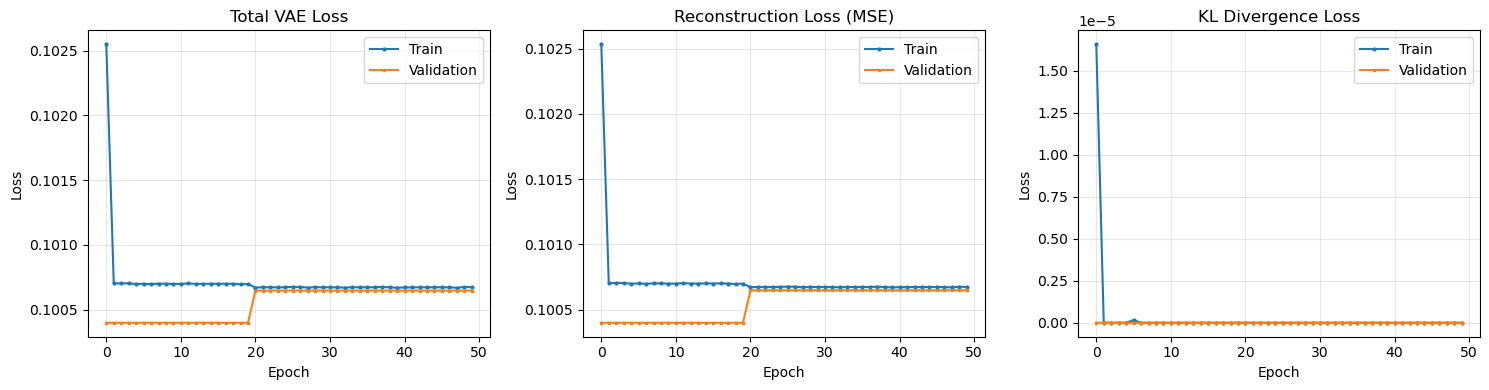

Training history plot saved to runs/ConvVAE64_MNIST_20260213_130237/training_history.png


In [17]:
# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Total loss
axes[0].plot(history['train_loss'], label='Train', marker='o', markersize=2)
axes[0].plot(history['val_loss'], label='Validation', marker='s', markersize=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Total VAE Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Reconstruction loss
axes[1].plot(history['train_recon_loss'], label='Train', marker='o', markersize=2)
axes[1].plot(history['val_recon_loss'], label='Validation', marker='s', markersize=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Reconstruction Loss (MSE)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# KL loss
axes[2].plot(history['train_kl_loss'], label='Train', marker='o', markersize=2)
axes[2].plot(history['val_kl_loss'], label='Validation', marker='s', markersize=2)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss')
axes[2].set_title('KL Divergence Loss')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"runs/{run_name}/training_history.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"Training history plot saved to runs/{run_name}/training_history.png")

## 9. Test Evaluation

In [18]:
# Load best model
best_checkpoint = torch.load(checkpoint_dir / "best_model.pt", map_location=device, weights_only=False)
model.load_state_dict(best_checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {best_checkpoint['epoch']}")

# Evaluate on test set
test_loss, test_recon, test_kl = validate(model, test_loader, device, beta=beta)
print(f"\nTest Loss: {test_loss:.6f} (Recon: {test_recon:.6f}, KL: {test_kl:.6f})")

Loaded best model from epoch 12


Validating: 100%|██████████| 157/157 [00:12<00:00, 12.93it/s, loss=0.134, recon=0.134, kl=5.82e-11]  

Loaded best model from epoch 12


Validating: 100%|██████████| 157/157 [00:12<00:00, 12.93it/s, loss=0.134, recon=0.134, kl=5.82e-11]  


Test Loss: 0.102858 (Recon: 0.102858, KL: 0.000000)


## 10. Reconstruction Visualization

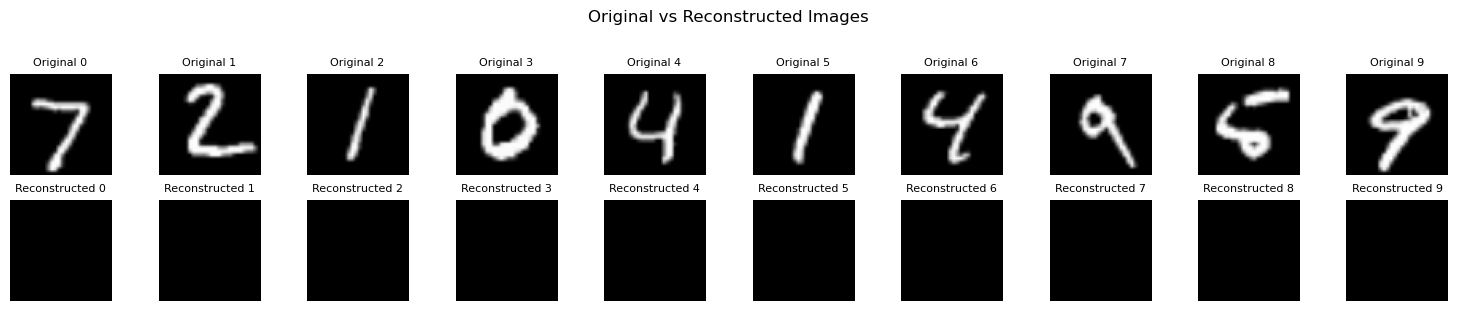

Reconstruction visualization saved to runs/ConvVAE64_MNIST_20260213_130237/reconstructions.png


In [19]:
# Get a batch for visualization
model.eval()
with torch.no_grad():
    test_images, _ = next(iter(test_loader))
    test_images = test_images.to(device)
    recon_images, _, _ = model(test_images)
    
    # Move to CPU for visualization
    test_images = test_images.cpu()
    recon_images = recon_images.cpu()

# Visualize original vs reconstructed
n_samples = 10
fig, axes = plt.subplots(2, n_samples, figsize=(15, 3))

for i in range(n_samples):
    # Original
    orig = test_images[i].permute(1, 2, 0).numpy()
    orig = np.clip(orig, 0, 1)
    axes[0, i].imshow(orig, cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Original {i}', fontsize=8)
    
    # Reconstructed
    recon = recon_images[i].permute(1, 2, 0).numpy()
    recon = np.clip(recon, 0, 1)
    axes[1, i].imshow(recon, cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title(f'Reconstructed {i}', fontsize=8)

plt.suptitle('Original vs Reconstructed Images', fontsize=12, y=1.02)
plt.tight_layout()
plt.savefig(f"runs/{run_name}/reconstructions.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"Reconstruction visualization saved to runs/{run_name}/reconstructions.png")